# First Take on Classification: Iteration on KNN




## Imports and Function Definitions:


In [2]:
import os
import numpy as np
import pandas as pd 
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from glob import glob
import matplotlib.pyplot as plt

def summary(array):
    min_val = np.min(array)
    max_val = np.max(array)
    sd = np.std(array)
    var = np.var(array)
    mean = np.mean(array)
    median = np.median(array)
    percentile25 = np.percentile(array, 25)
    percentile50 = np.percentile(array, 50)
    percentile75 = np.percentile(array, 75)
    
    summaryDict = {"max":max_val, 'min':min_val, "mean":mean, "median":median, "SD": sd, 
                   "var":var, "25th":percentile25, "50th": percentile50, "75th":percentile75 }
    return summaryDict

print(os.getcwd())
# print(os.listdir("./corn/train"))

d:\Programming\Python_code\PrinciplesOfDS_Course\finalProject


In [3]:
# center cropping function
def center_crop(img, target_size):
    h, w = img.shape[:2]
    th, tw = target_size

    if h < th or w < tw:
        raise ValueError("Target size should be smaller than the input image size")

    x = (w - tw) // 2
    y = (h - th) // 2
    cropped_img = img[y:y+th, x:x+tw]

    return cropped_img

## Preprocessing Data: 



In [4]:
# list files 
img_folder = './corn/train/*.png'
corn = glob(img_folder)

# preprocess images: center crop and normalization 
target_size = (140,140)
croppedImages = []

for imgPth in corn:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1]):
        croppedimg = center_crop(temp_img, target_size)
        croppedimg = (croppedimg / 255).astype(np.float32) # normalize
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        resizedImg = (resizedImg / 255).astype(np.float32) # normalize
        croppedImages.append(resizedImg)

In [5]:
# Greyscale conversion and HOG feature extraction 
croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in croppedImages_grey]

In [27]:
summary(hog_features)

{'max': 1.0,
 'min': 0.0,
 'mean': 0.12868448,
 'median': 0.1079078,
 'SD': 0.10591532,
 'var': 0.011218056,
 '25th': 0.041880153119564056,
 '50th': 0.10790780186653137,
 '75th': 0.1979237049818039}

In [33]:
hog_features[:2] # its a list of arrays. 
# sklearn is built to handle such input so long as all lists are of the same shape, which they are. 
print(len(hog_features[0]))
print(len(hog_features))

9216
14322


## Train and Tune Model:

In [6]:
# Load in label table: 
train_csv = pd.read_csv("./corn/train.csv")
print(train_csv.head())

labels = train_csv['label']
labels.head()

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


0        broken
1          pure
2        broken
3          pure
4    discolored
Name: label, dtype: object

In [7]:
# split data, train model, make predictions
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [8]:
# Evaluate the classifier on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))


              precision    recall  f1-score   support

      broken     0.7500    0.0749    0.1362       921
  discolored     0.1429    0.0020    0.0039       507
        pure     0.4168    0.9914    0.5868      1159
     silkcut     0.5556    0.0180    0.0348       278

    accuracy                         0.4272      2865
   macro avg     0.4663    0.2716    0.1904      2865
weighted avg     0.4889    0.4272    0.2853      2865



In [20]:
from sklearn.metrics import accuracy_score
print(y_test)
print(y_pred)
print(y_test.value_counts())

print("Accuracy:", accuracy_score(y_test, y_pred)) # .427 ... this would be ok, but honestly I think its because the model is just predicting the most common case a lot. 

2996         broken
304         silkcut
7588         broken
7047         broken
10494          pure
            ...    
6107           pure
12606          pure
408          broken
6908           pure
1608     discolored
Name: label, Length: 2865, dtype: object
['pure' 'pure' 'pure' ... 'pure' 'pure' 'pure']
pure          1159
broken         921
discolored     507
silkcut        278
Name: label, dtype: int64
Accuracy: 0.4272251308900524


<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


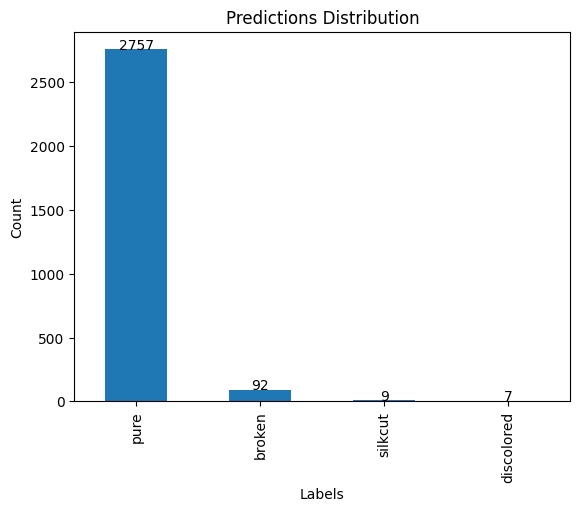

In [17]:
print(type(y_pred), type(y_test))
pred_series = pd.Series(y_pred)
#pred_series.hist(bins=len(set(y_pred)), rwidth=0.8)
ax = pred_series.value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Predictions Distribution')

for i, v in enumerate(pred_series.value_counts()):
    ax.text(x=i, y=v + 0.5, s=v, ha='center', fontsize=10)
    
plt.show()

In [14]:
pred_series.value_counts()

pure          2757
broken          92
silkcut          9
discolored       7
dtype: int64

## Cross Validation to find Neighbor number

In [21]:
from sklearn.model_selection import KFold, cross_val_score

In [25]:
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=20)

num_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 35, 50]

avg_accuracies = []

for neighbors in num_neighbors:
    # Create a KNN classifier with the current number of neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors)

    # Calculate the cross-validated accuracy for the current number of neighbors
    cv_accuracies = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
    print(cv_accuracies)
    # Compute the average accuracy across the folds
    avg_accuracy = np.mean(cv_accuracies)
    avg_accuracies.append(avg_accuracy)

    print(f"Neighbors: {neighbors}, Avg. Accuracy: {avg_accuracy:.4f}")



[0.43237347 0.44197208 0.4465299  0.4373636  0.43954605]
Neighbors: 1, Avg. Accuracy: 0.4396
[0.42670157 0.45855148 0.44827586 0.43867307 0.43037975]
Neighbors: 3, Avg. Accuracy: 0.4405
[0.42495637 0.45724258 0.44565692 0.43998254 0.41946748]
Neighbors: 5, Avg. Accuracy: 0.4375
[0.42146597 0.44502618 0.44565692 0.43212571 0.41510258]
Neighbors: 7, Avg. Accuracy: 0.4319
[0.42102967 0.44153578 0.43910956 0.42688782 0.41772152]
Neighbors: 9, Avg. Accuracy: 0.4293
[0.41535777 0.44022688 0.4373636  0.42077695 0.41684854]
Neighbors: 11, Avg. Accuracy: 0.4261
[0.41317627 0.43848168 0.43605412 0.42383239 0.41292012]
Neighbors: 13, Avg. Accuracy: 0.4249
[0.41317627 0.43630017 0.4325622  0.41990397 0.41161065]
Neighbors: 15, Avg. Accuracy: 0.4227
[0.40968586 0.43106457 0.43081624 0.41815801 0.4094282 ]
Neighbors: 17, Avg. Accuracy: 0.4198
[0.40968586 0.43106457 0.42994326 0.41422959 0.40986469]
Neighbors: 20, Avg. Accuracy: 0.4190
[0.40837696 0.43106457 0.42514186 0.41510258 0.40724574]
Neighbor

In [24]:
# Find the best number of neighbors based on the highest average accuracy
best_neighbors = num_neighbors[np.argmax(avg_accuracies)]
print(f"\nBest number of neighbors: {best_neighbors}")


Best number of neighbors: 3
